## Functions

In [2]:
import pandas as pd
from skimage import io
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def reverse_element(list_of_pairs):
  ''' Revserse the lists inside a list
  
  '''
  reversed_list = []
  for pair in list_of_pairs:
    first = pair[0]
    second = pair[1]
    reversed_list.append([second, first])
  return reversed_list

In [4]:
def calculate_threshold(ratio_ls, origin_threshold_ls):
  updated_threshold_ls = []
  for ratio, orign_threshold in zip(ratio_ls, origin_threshold_ls):
    updated_threshold = ratio * orign_threshold
    updated_threshold_ls.append(updated_threshold)
  return updated_threshold_ls

In [25]:
def add_annotation(is_swapped, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value):
  ''' Add rectangles and texts to a image
  
  '''
  color = 'y'
  if is_swapped:
    color = 'r'
    draw_rect(ax, xy, tile_height, tile_width)
  add_text(tile_height, tile_width, ax, xy, color, cur_value, avg_value, threshold)

In [74]:
def add_text(tile_height, tile_width, ax, xy, color, cur_value, avg_value, threshold):
  ''' Add text to the corresponding tile
  '''
  rx, ry = xy[0], xy[1]
  cx = rx + tile_width / 2.0
  cy = ry + tile_height / 2.0

  num = cur_value - avg_value
  str_int_cur_value = str(int(cur_value)) 
  str_int_avg_value = str(int(avg_value)) 
  str_int_threshold = str(int(threshold))

  if num != 0:
    txt = str_int_cur_value + '-' + str_int_avg_value
    txt += '\n(' + str_int_threshold + ')'
  else:
    txt = str_int_avg_value
  ax.annotate(txt, (cx, cy), fontsize=4, color=color, ha='center', va='center')

In [75]:
# Circle the rectangle of the corresponding tile
def draw_rect(ax, xy, tile_height, tile_width):
  rect = patches.Rectangle(xy, tile_width, tile_height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

In [8]:
# Collect the needed index based on the wanted bands
def get_wanted_image_band(selected_band, img):
  selected_img = np.array(img[:,:,selected_band])
  selected_img = np.reshape(selected_img, (selected_img.shape[0], selected_img.shape[1], 1))
  return selected_img

In [48]:
# Reshape the selected bands based on the number of channels
def select_mask_region(tile_height, tile_width, img, epiweek, all_index, swapped_index, cur_tile_ls, threshold_ls, avg_tile_ls):

  # Create figure and axes
  fig, ax = plt.subplots(constrained_layout=True)
  img = img.reshape(img.shape[0], img.shape[1])
  ax.axis('off')
  ax.imshow(img, cmap='gray')

  for i in all_index:
    xy = xy_pairs[i]
    cur_value = cur_tile_ls[i]
    avg_value = avg_tile_ls[i]
    threshold = threshold_ls[i]
    if i in swapped_index:
      add_annotation(True, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value)
    else:
      add_annotation(False, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value)

  plt.title(str(epiweek))
  folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/tiles/' + str(tiles_in_band) + '_tiles/'
  check_folder(folder)
  plt.savefig(folder + str(epiweek) + '.jpg', dpi=150)
  plt.show()

In [11]:
# Select the index
def obtain_index_range(selected_band):
  selected_index = [*range(tiles_in_band * selected_band, tiles_in_band * selected_band + tiles_in_band)]
  selected_index = np.array(selected_index).flatten()
  print('Selected tile index to analyze:', selected_index)
  return selected_index

In [12]:
def check_folder(path):
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)

  # Create a new directory because it does not exist 
  if not isExist:
    os.makedirs(path)

In [14]:
def load_csv_to_dict(filename):
  # Create a dictionary to store wanted columns from CSV
  dic = {
      'epiweek': [],
      'image': [],
      'cases': []
      }
  
  df = pd.read_csv(filename)
  # Read images from folder
  for index, row in df.iterrows():
    img_loc = row['img_loc']
    img = io.imread(img_loc)

    dic['image'].append(img)
    dic['epiweek'].append(row['YearWeek'])
    dic['cases'].append(row['cases_medellin'])

  dic['epiweek'] = np.array(dic['epiweek'])
  dic['image'] = np.array(dic['image'])
  dic['cases'] = np.array(dic['cases'])

  return dic

In [15]:
def get_pixels_per_tile(img, height_split, width_split):
  # Get height, width, band from the image's shape
  height, width, band = img.shape
  
  # Count height and width pixel for a tile 
  tile_height = int(height / height_split)
  tile_width = int(width / width_split)
  return tile_height, tile_width

In [16]:
def run_tile_transformation_on_all(img_ls, selected_band, tile_height, tile_width):
  # Perform image to tile transformation for every image 
  all_img_tiles = []

  for img in img_ls:
    img_tiles = split_img_to_tiles(1, img, selected_band, tile_height, tile_width)
    all_img_tiles.append(img_tiles)
  return all_img_tiles

In [35]:
# Split images into tiles by indicating the window size for rows and columns
def split_img_to_tiles(option, img, selected_band, windowsize_r, windowsize_c, avg_img=None):
  return_ls = []
  height = img.shape[0] 
  width = img.shape[1]

  for r in range(0, height - windowsize_r + 1, windowsize_r):
    for c in range(0, width - windowsize_c + 1, windowsize_c):

      if option == 0:
        return_ls.append([r, c])
      
      elif option == 1:
        window = img[r:r+windowsize_r, c:c+windowsize_c, selected_band:selected_band+1]
        window_avg = round(np.average(window), 2)
        return_ls.append(window_avg)

      elif option == 2:
        avg_tile = avg_img[r:r+windowsize_r, c:c+windowsize_c, selected_band:selected_band+1]
        cur_tile = cur_img[r:r+windowsize_r, c:c+windowsize_c, selected_band:selected_band+1]
        p_value = get_p_value(avg_tile.flatten(), cur_tile.flatten())
        return_ls.append(p_value)

  return np.array(return_ls)

In [40]:
from scipy.stats import ttest_rel
def get_p_value(base_list, compared_list):
  ttest = ttest_rel(base_list, compared_list)
  print(ttest)
  return ttest.pvalue

In [49]:
def check_every_tile_with_p_value(tile_height, tile_width, p_value_ls, cur_tile_ls, avg_tile_ls):
  updated_img_tiles = cur_tile_ls.copy()
  removed_tiles_counter = 0
  swapped_index_list = []
  num_of_tiles = len(avg_tile_ls)
  threshold = 0.0001

  for i in range(num_of_tiles):
    if p_value_ls[i] < threshold:
      swapped_index_list.append(i)
      updated_img_tiles[i] = avg_tile_ls[i]
      removed_tiles_counter += 1

  selected_img = get_wanted_image_band(selected_band, img)
  select_mask_region(tile_height, tile_width, selected_img, epiweek, range(num_of_tiles), swapped_index_list, cur_tile_ls, p_value_ls, avg_tile_ls)

  ratio = removed_tiles_counter / num_of_tiles
  return updated_img_tiles, ratio

In [55]:
def check_every_tile_with_std(tile_height, tile_width, threshold_list, cur_tile_ls, avg_tile_ls):
  updated_img_tiles = tiles.copy()
  removed_tiles_counter = 0
  swapped_index = []
  num_of_tiles = len(avg_tile_ls)

  for i in range(num_of_tiles):
    threshold = threshold_list[i]
    
    cur_tile_value = cur_tile_ls[i]
    avg_tile_value = avg_tile_ls[i]
    diff = np.absolute(cur_tile_value - avg_tile_value)
    
    if diff > threshold:
      swapped_index.append(i)
      updated_img_tiles[i] = avg_tile_value
      removed_tiles_counter += 1

  selected_img = get_wanted_image_band(selected_band, img)
  select_mask_region(tile_height, tile_width, selected_img, epiweek, range(num_of_tiles), swapped_index, cur_tile_ls, threshold_ls, avg_tile_ls)

  ratio = removed_tiles_counter / num_of_tiles
  return updated_img_tiles, ratio

In [22]:
dataset_main_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'
filename = dataset_main_folder + '/csv/matched_12_band.csv'
data_dic = load_csv_to_dict(filename)

## Setup

In [56]:
# Select the band for LSTM model (can only select one for now)
selected_band = 0

# Indicate which threshold calculation method to use for tile swapping 
# Available options: std, ttest
threshold_method = 'std'

# Set the numbers of split for height and width
height_split = 16
width_split = 8

# Set train-test ratio 
train_val_ratio = 0.8

## Plot selected tiles

In [57]:
# Read the training set's average image 
avg_img_folder = os.path.join(dataset_main_folder, 'analysis', 'train_average_img.tiff')
avg_img = tifffile.imread(avg_img_folder)

print('Image shape:', avg_img.shape)
print('Image dtype:', avg_img.dtype)
print('-----------')
flat_avg_img = avg_img.flatten()
print('Max pixel value:', max(flat_avg_img))
print('Min pixel value:', min(flat_avg_img))
print('-----------')

tile_height, tile_width = get_pixels_per_tile(avg_img, height_split, width_split)

# Split the average image into multiple tiles
avg_img_tiles = split_img_to_tiles(1, avg_img, selected_band, tile_height, tile_width)
print('[avg_img_tiles] Average pixel value:', np.average(avg_img_tiles))

all_img_tiles = run_tile_transformation_on_all(data_dic['image'], selected_band, tile_height, tile_width)
print('[All samples] Average pixel value:', np.average(all_img_tiles))

Image shape: (1205, 765, 12)
Image dtype: uint8
-----------
Max pixel value: 148
Min pixel value: 6
-----------
[avg_img_tiles] Average pixel value: 45.18656250000001
[All samples] Average pixel value: 45.96784637721238


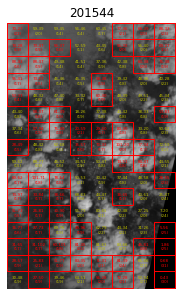

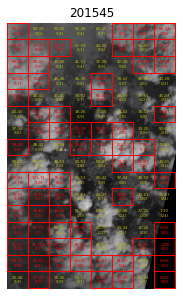

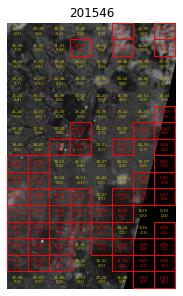

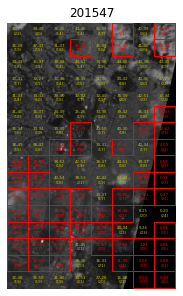

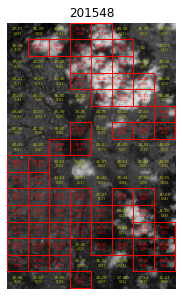

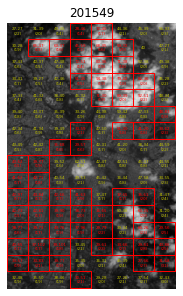

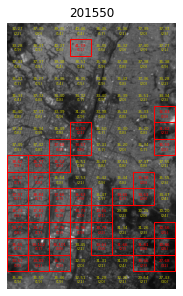

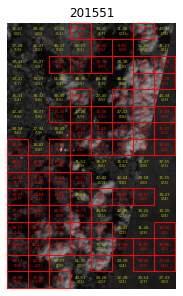

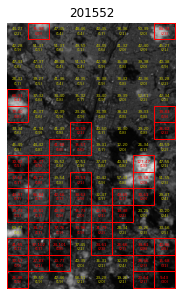

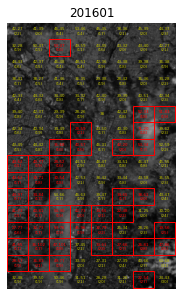

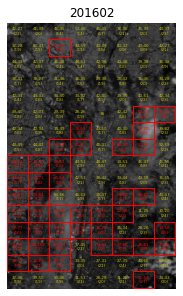

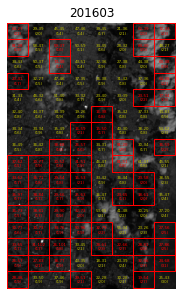

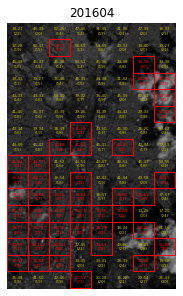

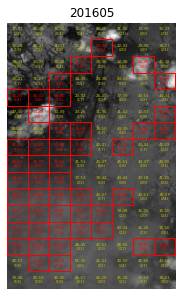

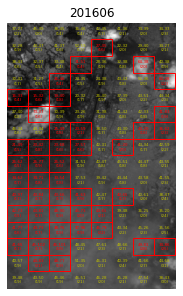

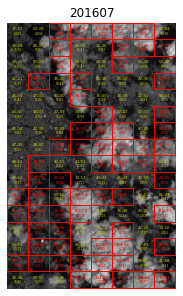

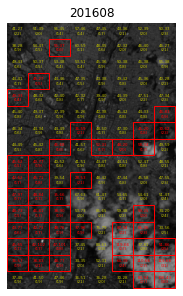

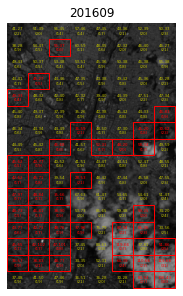

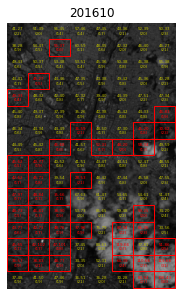

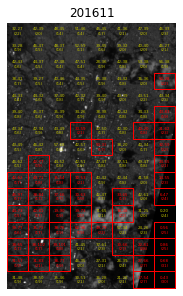

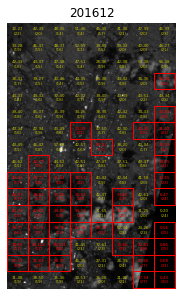

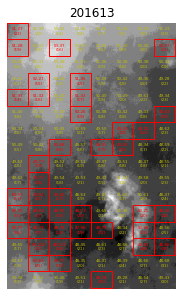

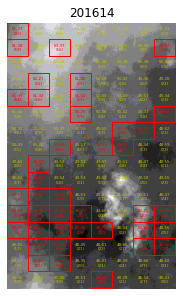

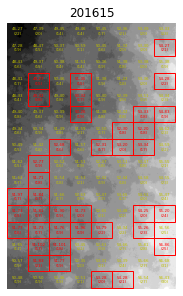

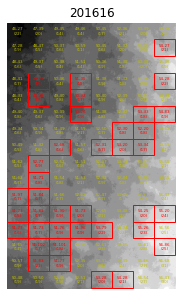

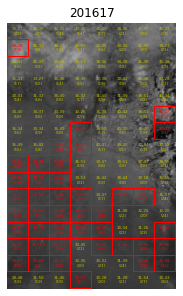

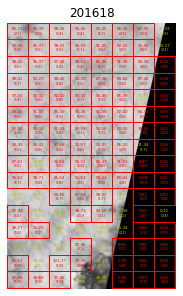

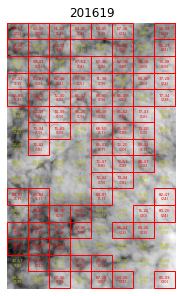

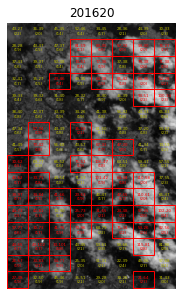

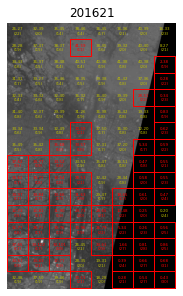

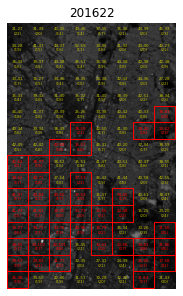

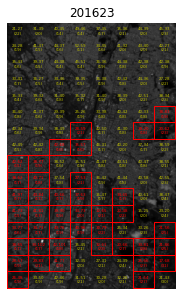

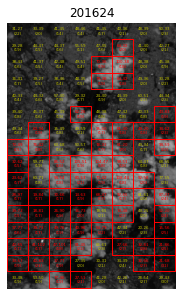

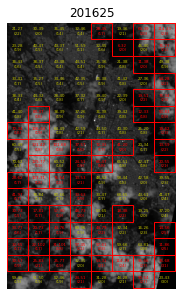

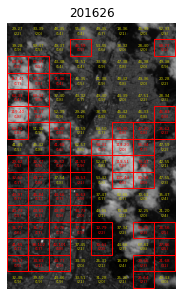

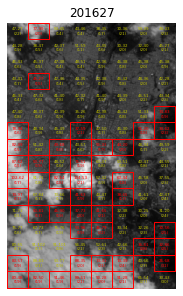

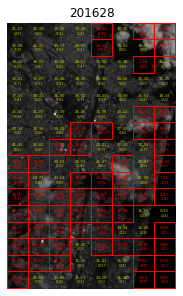

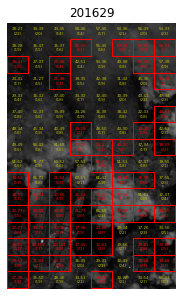

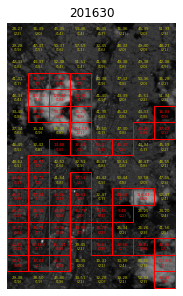

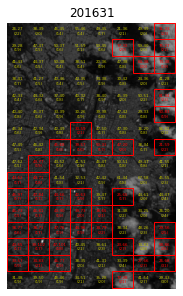

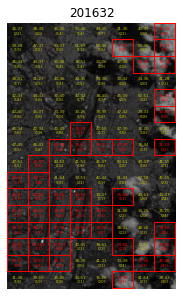

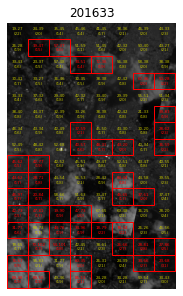

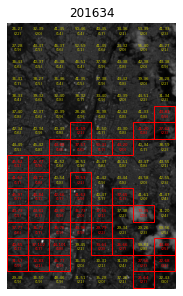

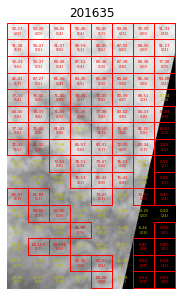

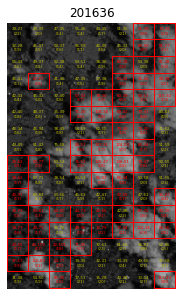

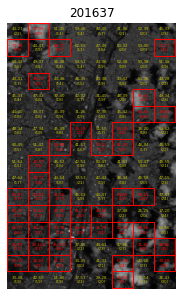

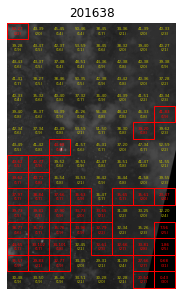

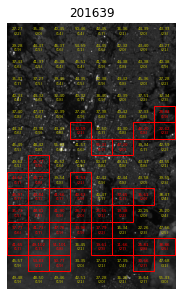

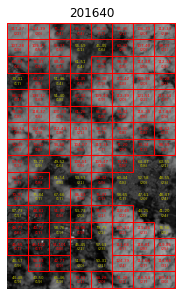

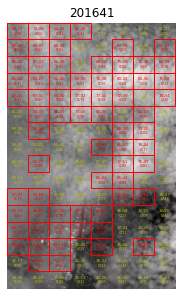

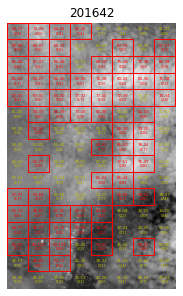

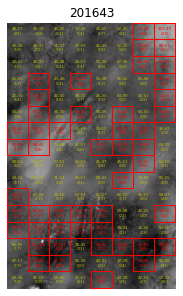

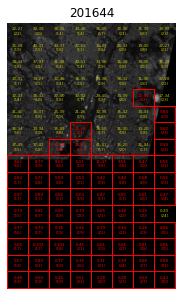

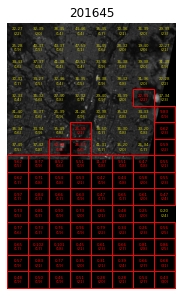

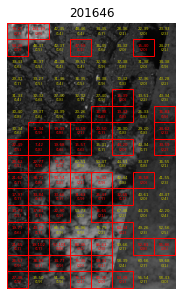

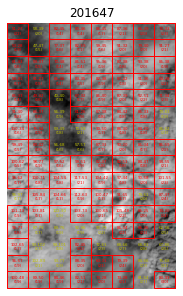

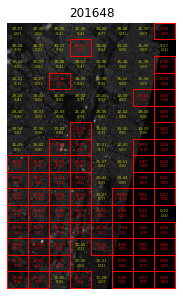

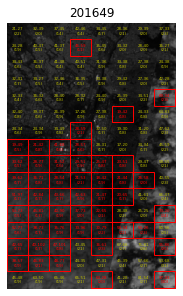

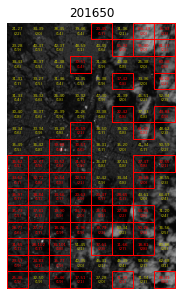

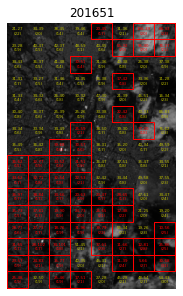

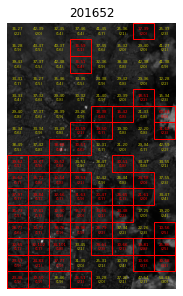

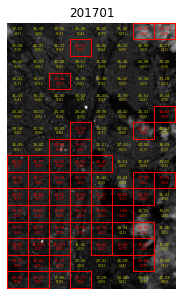

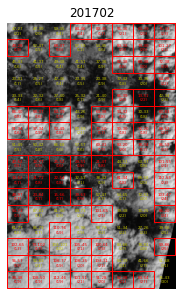

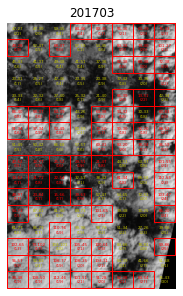

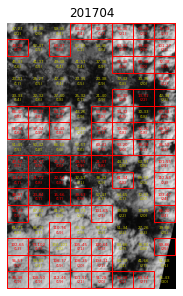

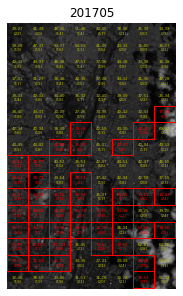

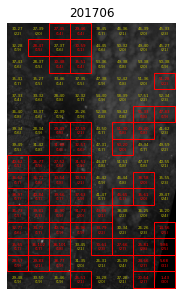

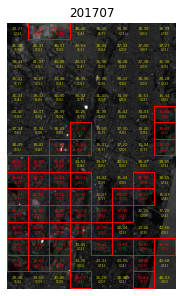

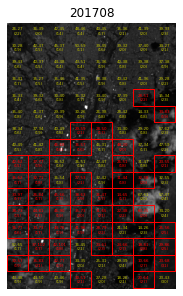

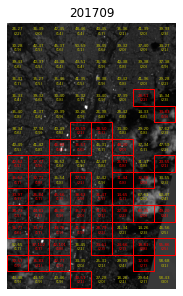

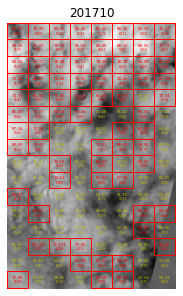

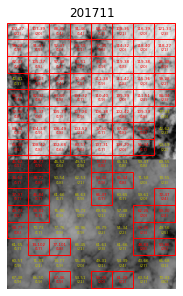

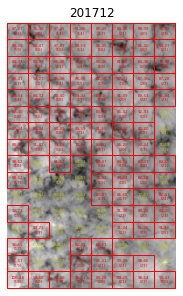

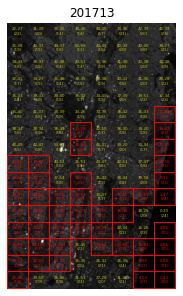

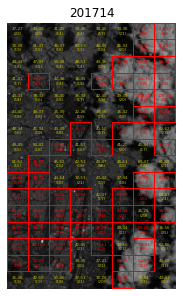

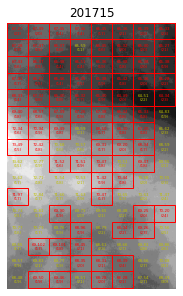

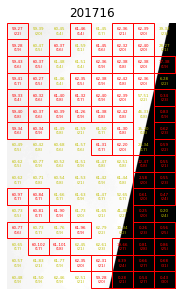

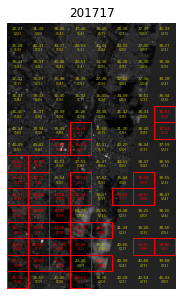

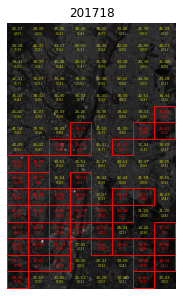

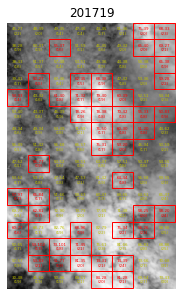

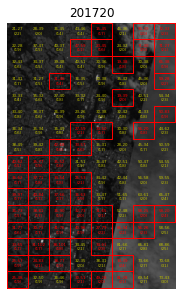

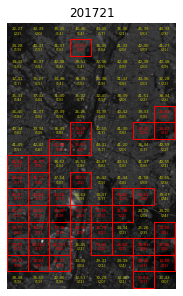

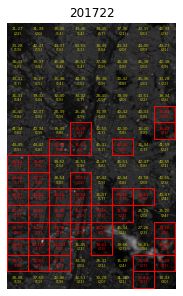

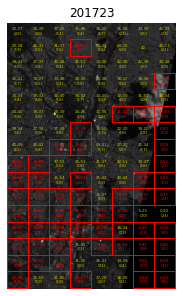

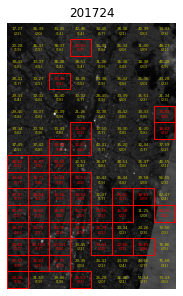

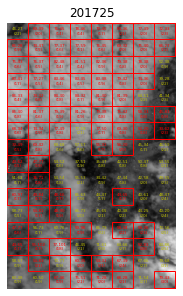

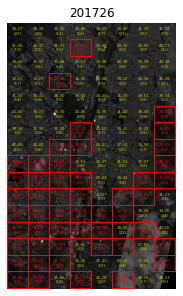

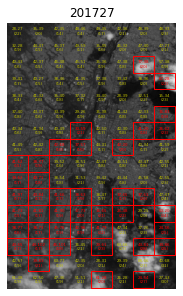

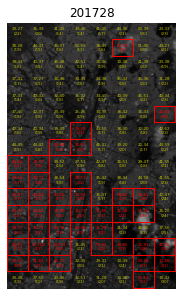

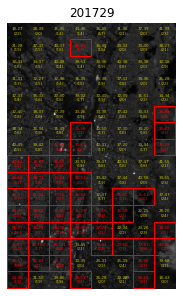

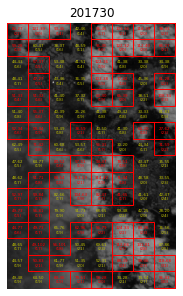

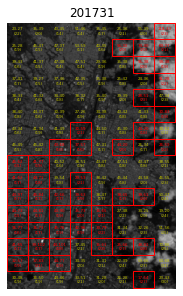

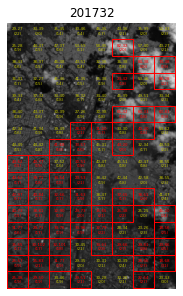

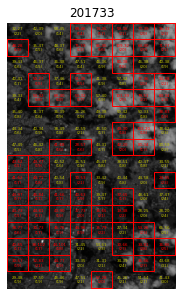

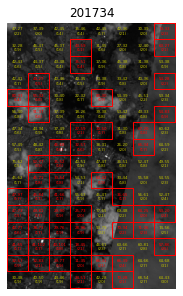

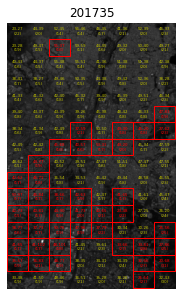

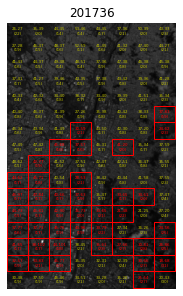

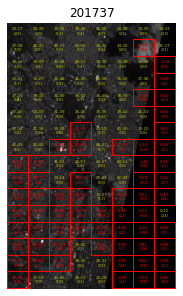

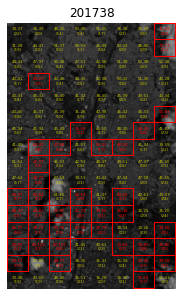

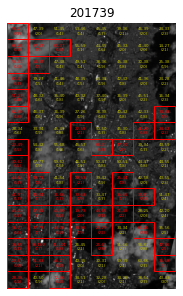

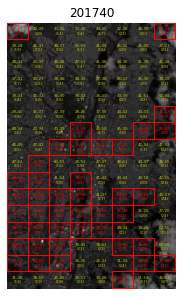

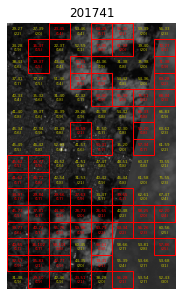

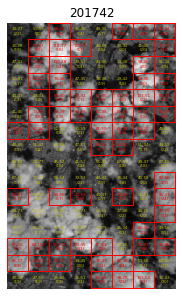

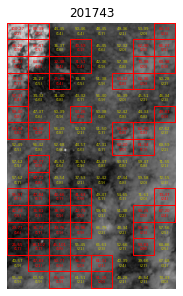

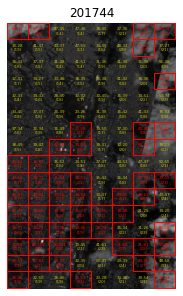

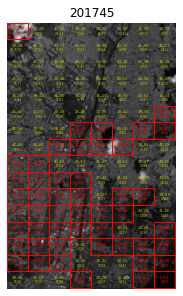

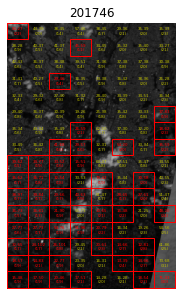

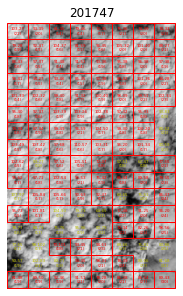

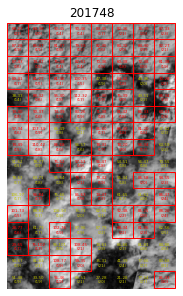

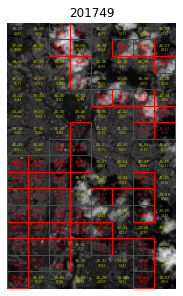

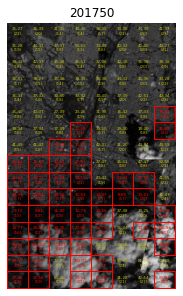

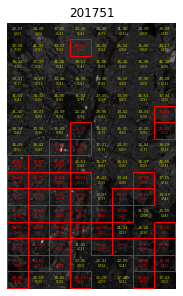

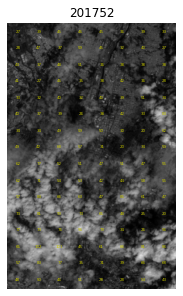

In [76]:
row_col_pairs = split_img_to_tiles(0, avg_img, selected_band, tile_height, tile_width)
xy_pairs = reverse_element(row_col_pairs)
tiles_in_band = height_split * width_split

selected_win_list = []
swapped_ratio_list = []

# Available options: std, ttest
if threshold_method == 'std':
  threshold_ls = []

  # Calculate the standard deviation for each tile
  tile_std = np.std(all_img_tiles, axis=0)  

  ratio_ls = np.ones((tiles_in_band, 1))
  threshold_ls = calculate_threshold(ratio_ls, tile_std)

  for tiles, img, epiweek in zip(all_img_tiles, data_dic['image'], data_dic['epiweek']):
    updated_img_tiles, ratio = check_every_tile_with_std(tile_height, tile_width, threshold_ls, tiles, avg_img_tiles)  
    selected_win_list.append(updated_img_tiles)
    swapped_ratio_list.append(ratio)

else:
  p_value_ls = []
  img_ls = data_dic['image']
  for cur_img in img_ls:
    p_value = split_img_to_tiles(2, cur_img, selected_band, tile_height, tile_width, avg_img=avg_img)
    p_value_ls.append(p_value)

  for tiles, img, epiweek, p_value in zip(all_img_tiles, data_dic['image'], data_dic['epiweek'], p_value_ls):
    updated_img_tiles, ratio = check_every_tile_with_p_value(tile_height, tile_width, p_value, tiles, avg_img_tiles)  
    selected_win_list.append(updated_img_tiles)
    swapped_ratio_list.append(ratio)

In [62]:
print(len(selected_win_list))
print(len(swapped_ratio_list))
print(np.average(swapped_ratio_list))

113
113
0.22538716814159293


## LSTM

### Setup

### Main

In [70]:
X = np.array(selected_win_list)
scaler = MinMaxScaler(feature_range=(0, 1)) 
y = scaler.fit_transform(data_dic['cases'].reshape(-1, 1)) 
print(X.shape, y.shape)
print(y)

(113, 128) (113, 1)
[[0.15397924]
 [0.18512111]
 [0.15743945]
 [0.14359862]
 [0.20934256]
 [0.20069204]
 [0.23010381]
 [0.30103806]
 [0.35813149]
 [0.38235294]
 [0.44982699]
 [0.41176471]
 [0.42906574]
 [0.44982699]
 [0.43598616]
 [0.38062284]
 [0.42214533]
 [0.44636678]
 [0.30276817]
 [0.38581315]
 [0.44636678]
 [0.56747405]
 [0.5       ]
 [0.61937716]
 [0.58650519]
 [0.56920415]
 [0.69723183]
 [0.74913495]
 [0.77854671]
 [0.78373702]
 [0.79584775]
 [0.86678201]
 [0.88754325]
 [0.88754325]
 [0.8650519 ]
 [1.        ]
 [0.88581315]
 [0.7733564 ]
 [0.80276817]
 [0.84256055]
 [0.8200692 ]
 [0.9083045 ]
 [0.78200692]
 [0.66782007]
 [0.62975779]
 [0.56747405]
 [0.5432526 ]
 [0.58823529]
 [0.43079585]
 [0.42906574]
 [0.41695502]
 [0.36678201]
 [0.29584775]
 [0.29411765]
 [0.30795848]
 [0.28892734]
 [0.22318339]
 [0.17647059]
 [0.19031142]
 [0.18685121]
 [0.16608997]
 [0.12975779]
 [0.14705882]
 [0.11072664]
 [0.09515571]
 [0.07439446]
 [0.06574394]
 [0.05709343]
 [0.06401384]
 [0.06228374]


In [71]:
train_val_ratio = 0.8
train_num = int(len(y) * train_val_ratio)

X_train = X[:train_num,:]
X_test = X[train_num:,:]
y_train = y[:train_num]
y_test = y[train_num:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(list(y_train))
print(list(y_test))

(90, 128) (23, 128) (90, 1) (23, 1)
[array([0.15397924]), array([0.18512111]), array([0.15743945]), array([0.14359862]), array([0.20934256]), array([0.20069204]), array([0.23010381]), array([0.30103806]), array([0.35813149]), array([0.38235294]), array([0.44982699]), array([0.41176471]), array([0.42906574]), array([0.44982699]), array([0.43598616]), array([0.38062284]), array([0.42214533]), array([0.44636678]), array([0.30276817]), array([0.38581315]), array([0.44636678]), array([0.56747405]), array([0.5]), array([0.61937716]), array([0.58650519]), array([0.56920415]), array([0.69723183]), array([0.74913495]), array([0.77854671]), array([0.78373702]), array([0.79584775]), array([0.86678201]), array([0.88754325]), array([0.88754325]), array([0.8650519]), array([1.]), array([0.88581315]), array([0.7733564]), array([0.80276817]), array([0.84256055]), array([0.8200692]), array([0.9083045]), array([0.78200692]), array([0.66782007]), array([0.62975779]), array([0.56747405]), array([0.5432526

Final input: (80, 10, 128) (13, 10, 128)
------------------------------------------
Final output: (80, 1) (13, 1)


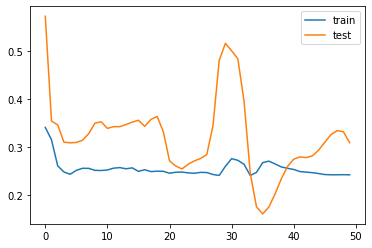

Test MAE: 178.903
Predicted: [[238.38164]
 [236.96887]
 [133.15053]
 [238.32652]
 [133.4384 ]
 [190.81865]
 [248.41197]
 [238.40154]
 [209.94597]
 [220.00974]
 [237.20119]
 [136.2722 ]
 [185.41283]]
Real: [[31.]
 [29.]
 [27.]
 [27.]
 [24.]
 [27.]
 [22.]
 [28.]
 [21.]
 [30.]
 [14.]
 [22.]
 [19.]]


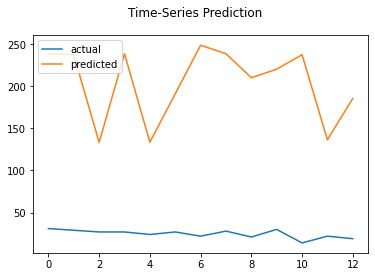

In [72]:
# frame as supervised learning
weeks = 10
train = series_to_supervised(X_train, n_in=weeks)
test = series_to_supervised(X_test, n_in=weeks)

n_features = X.shape[1]
train_np, test_np = train.to_numpy(), test.to_numpy()

clean_train = removeLastWeek(train_np, n_features)
clean_test = removeLastWeek(test_np, n_features)

final_X_train = clean_train.reshape((-1, weeks, n_features))
final_X_test = clean_test.reshape((-1, weeks, n_features))
print('Final input:', final_X_train.shape, final_X_test.shape)

print('------------------------------------------')
final_y_train = y_train[weeks:]
final_y_test = y_test[weeks:]
print('Final output:', final_y_train.shape, final_y_test.shape)

evalModel(final_X_train, final_X_test, final_y_train, final_y_test, scaler)

In [73]:
#https://github.com/MITCriticalData-Colombia/Dengue-MetaData/blob/fusion_time_series/multi_var_time_series/LSTM_multivariate_v2_weekly_temperature.ipynb

## Others

### Show what the average training image looks like in different bands

Selected tile index to analyze: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


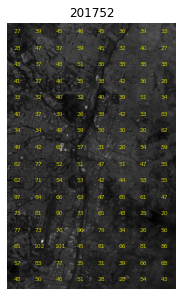

Selected tile index to analyze: [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255]


IndexError: ignored

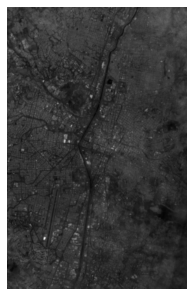

In [64]:
# avg_img = tifffile.imread(avg_img_folder)
# avg_img_tiles = split_img_to_tiles(1, cur_img, selected_band, tile_height, tile_width)

# for i in range(12):
#   all_index = obtain_index_range(i)
#   selected_img = get_wanted_image_band(i, avg_img)
#   img_name = 'avg_img_band_' + str(i)
#   select_mask_region(tile_height, tile_width, selected_img, epiweek, all_index, [], avg_img_tiles, threshold_ls, avg_img_tiles)

#   # select_mask_region(index_in_range, selected_img, [], img_name, avg_img_tiles, threshold_list, avg_img_tiles)

### Correlation & covariance

In [65]:
# img_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/'
# real_avg_img = tifffile.imread(img_folder + "average_img.tiff")

# height, width, band = real_avg_img.shape
# real_avg_win = split_img_to_tiles(real_avg_img, int(height/height_split), int(width/width_split)) 

# reshaped_avg_win = real_avg_win.reshape((12, -1))
# print(reshaped_avg_win.shape)

# import seaborn as sns
# cov = np.cov(reshaped_avg_win)
# ax = sns.heatmap(cov, linewidth=0.5)
# plt.title('Covariance')
# plt.show()

# corr = np.corrcoef(reshaped_avg_win)
# ax = sns.heatmap(corr, linewidth=0.5)
# plt.title('Correlation')
# plt.show()

TypeError: ignored

In [66]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [67]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [(f'var({j+1})') for j in range(n_vars)]
    else:
      names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]

  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [68]:
def removeLastWeek(data, n_features):
  return data[:,:-n_features]

In [69]:
def evalModel(X_train, X_test, y_train, y_test, scaler):
  tf.random.set_seed(1)

  # design network
  model = Sequential()
  model.add(LSTM(60, input_shape=(X_train.shape[1], 
                                  X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  history = model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=72, 
                      validation_data=(X_test, y_test))
  
  
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()


  # make a prediction
  yhat = model.predict(X_test)
  yhat = scaler.inverse_transform(yhat)
  y_test = scaler.inverse_transform(y_test)
  mae = mean_absolute_error(y_test, yhat)
  print('Test MAE: %.3f' % mae)

  data_predict = yhat.reshape(len(yhat), 1) # predicted target cases
  dataY_plot = y_test.reshape(len(y_test), 1) # real test-target cases
  print('Predicted:', data_predict)
  print('Real:', dataY_plot)

  plt.plot(dataY_plot, label = 'actual')
  plt.plot(data_predict, label = 'predicted')
  plt.legend(loc="upper left")
  plt.suptitle('Time-Series Prediction')
  plt.show()

### HTML with Colab

In [ ]:
from IPython.display import HTML, display
from google.colab import output

result_html = """
    <h1>Hello</h1>
  """
display(HTML(result_html))